In [62]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")  #input the file


In [63]:
## create copy of df and retain only units dealing with L amounts
retain_unit = ['ML','L', 'µL']
df_liquid = df[df.Unit.isin(retain_unit)]    
df_liquid.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date
0,100565,100000340,B23120,134,1,952.0,L,954.0,2016-10-30,2016-11-07,2016-11-01,2016-11-01,2016-11-01,2016-11-09
17,100448,100000449,B25472,143,12,100.0,ML,0.0,2016-11-15,2016-11-18,NaT,NaT,2016-10-30,2017-12-06
19,100673,100000999,B23766,131,1,2200.0,ML,0.0,2016-11-02,2016-11-04,2016-11-08,NaT,2016-10-30,2016-11-09
21,100078,100001714,B23664,129,1,2.5,L,0.0,2016-11-02,2016-11-08,2016-11-17,NaT,2016-10-30,2016-11-29
22,100480,100001190,B22633,143,12,3000.0,ML,0.0,2016-11-11,2016-11-18,2016-11-04,NaT,2016-10-30,2017-01-13


In [66]:
#Create colummns for actual duration and scheduled duration
df_liquid['scheduled_duration_nowkend'] = df_liquid.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df_liquid['actual_duration_nowkend'] = df_liquid.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

#Change the units to ML ****** 
df_liquid.loc[df_liquid["Unit"] == "µL", "Total order quantity"] /= 1000
df_liquid.loc[df_liquid["Unit"] == "L", "Total order quantity"] *= 1000
df_liquid["Unit"] = "ML"



#Put df in chronological order
df_liquid = df_liquid.sort_values("Confirmation Start Date", ascending = 1)

#Remove NaN values
df_liquid = df_liquid.dropna()

In [67]:
#X: input features
#Y: target variable 

X = df_liquid[['Group', 'MaterialCategory', 'Total order quantity', 'Confirmation Start Date', 'scheduled_duration_nowkend']]
Y = df_liquid['actual_duration_nowkend']

In [68]:
#Training Data for Prophet

pro_df = pd.DataFrame()
pro_df['ds'] = X['Confirmation Start Date']
pro_df['y'] = Y


In [69]:
#Multiple Regressors

pro_df['Group'] = X['Group']
pro_df['MaterialCategory'] = X['MaterialCategory']
pro_df['Total order quantity'] = X['Total order quantity']

train_df = pro_df[ : 23239 ]
test_df = pro_df[23239: ]
test_df.head()

,ds,y,Group,MaterialCategory,Total order quantity
24507,2019-04-14,12,130,1,3920000.0
24482,2019-04-14,15,134,1,1000000.0
24511,2019-04-14,16,134,1,2700.0
24510,2019-04-14,18,130,1,10000000.0
24344,2019-04-14,17,131,1,1300.0


In [74]:
r = Prophet(yearly_seasonality = True, daily_seasonality = True)
r.add_regressor('MaterialCategory')
r.add_regressor('Group')

r.fit(train_df)
#future_r = r.make_future_dataframe(periods = 365)


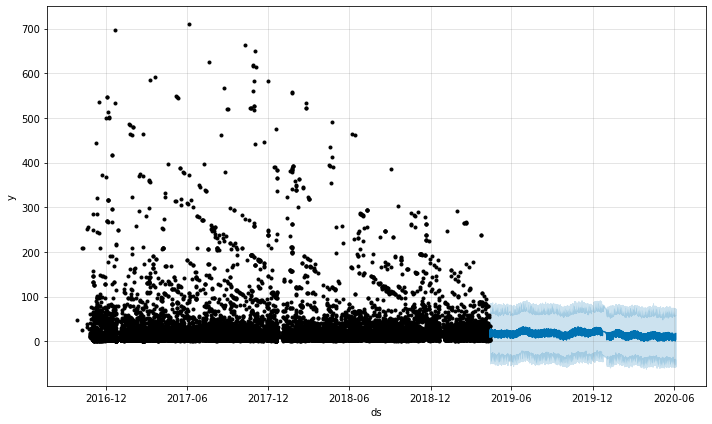

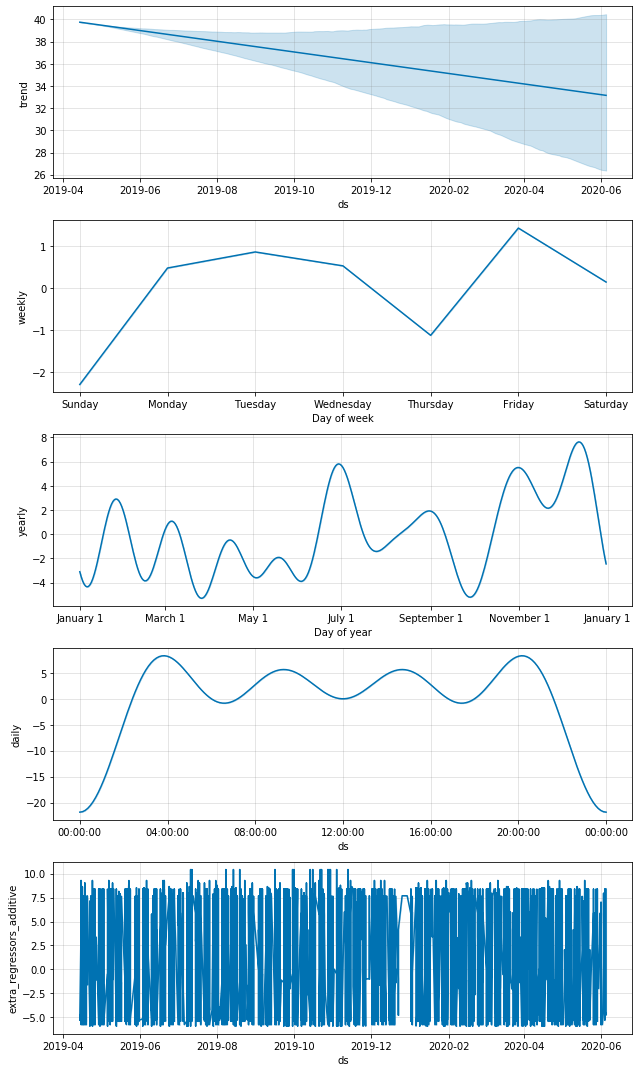

In [75]:
forecast_r = r.predict(test_df) 

fig3 = r.plot(forecast_r) 
fig4 = r.plot_components(forecast_r)

In [72]:
test_df.head(10)

,ds,y,Group,MaterialCategory,Total order quantity
24507,2019-04-14,12,130,1,3920000.0
24482,2019-04-14,15,134,1,1000000.0
24511,2019-04-14,16,134,1,2700.0
24510,2019-04-14,18,130,1,10000000.0
24344,2019-04-14,17,131,1,1300.0
24513,2019-04-14,43,134,1,3000.0
24091,2019-04-14,20,130,1,10000000.0
24503,2019-04-14,8,130,1,2700000.0
24489,2019-04-14,14,134,1,373000.0
24217,2019-04-14,14,131,1,7200.0


In [76]:
forecast_r.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Group,Group_lower,Group_upper,MaterialCategory,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-14,39.753304,-44.841486,65.790074,39.753304,39.753304,0.124769,0.124769,0.124769,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.809085
1,2019-04-14,39.753304,-42.825160,66.415546,39.753304,39.753304,0.124769,0.124769,0.124769,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.809085
2,2019-04-14,39.753304,-49.133349,68.485499,39.753304,39.753304,0.632295,0.632295,0.632295,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,10.316612
3,2019-04-14,39.753304,-42.433656,65.324153,39.753304,39.753304,0.251650,0.251650,0.251650,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.935967
4,2019-04-14,39.753304,-43.186463,64.378690,39.753304,39.753304,0.251650,0.251650,0.251650,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.935967
5,2019-04-14,39.753304,-44.481531,65.192474,39.753304,39.753304,0.251650,0.251650,0.251650,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.935967
6,2019-04-14,39.753304,-45.904311,60.914413,39.753304,39.753304,0.632295,0.632295,0.632295,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,10.316612
7,2019-04-14,39.753304,-47.703068,65.143286,39.753304,39.753304,0.632295,0.632295,0.632295,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,10.316612
8,2019-04-14,39.753304,-41.580902,66.264367,39.753304,39.753304,0.124769,0.124769,0.124769,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,9.809085
9,2019-04-14,39.753304,-43.552264,65.527822,39.753304,39.753304,0.632295,0.632295,0.632295,-5.398247,...,-2.285465,-2.285465,-2.285465,-0.528275,-0.528275,-0.528275,0.0,0.0,0.0,10.316612


In [ ]:
#MSE Calculations - to check how well the model predicted the test data

